# Chapter 3. Foundational Components of Neural Networks

This chapter sets the stage for later chapters by introducing the basic ideas involved in building neural networks, such as activation functions, loss functions, optimizers, and the supervised training setup. We begin by looking at the perceptron, a one-unit neural network, to tie together the various concepts. The perceptron itself is a building block in more complex neural networks. This is a common pattern that will repeat itself throughout the book—every architecture or network we discuss can be used either standalone or compositionally within other complex networks. This compositionality will become clear as we discuss computational graphs and the rest of this book.

## The Perceptron: The Simplest Neural Network

The simplest neural network unit is a perceptron. The perceptron was historically and very loosely modeled after the biological neuron. As with a biological neuron, there is input and output, and “signals” flow from the inputs to the outputs, as illustrated in Figure 3-1.

<div align="center" style="width: 100%;">
    <div align="center" style="width: 600px">
        <img src="imgs/nlpp_0301.png">
        <h4 style="font-family: courier; font-size: .8em;">Figure 3-1. The computational graph for a perceptron with an input (x) and an output (y). The weights (w) and bias (b) constitute the parameters of the model.</h4>
    </div>
</div>

Each perceptron unit has an input (x), an output (y), and three “knobs”: a set of weights (w), a bias (b), and an activation function (f). The weights and the bias are learned from the data, and the activation function is handpicked depending on the network designer’s intuition of the network and its target outputs. Mathematically, we can express this as follows:

$$\LARGE y = f ( wx + b )$$

It is usually the case that there is more than one input to the perceptron. We can represent this general case using vectors. That is, x, and w are vectors, and the product of w and x is replaced with a dot product:

$$\LARGE y = f ( wx + b )$$

The activation function, denoted here by f, is typically a nonlinear function. A linear function is one whose graph is a straight line. In this example, wx+b is a linear function. So, essentially, a perceptron is a composition of a linear and a nonlinear function. The linear expression wx+b is also known as an affine transform.

Example 3-1 presents a perceptron implementation in PyTorch that takes an arbitrary number of inputs, does the affine transform, applies an activation function, and produces a single output.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
class Perceptron(nn.Module):
    """ A perceptron is one linear layer """
    def __init__(self, input_dim):
        """
        Args:
            input_dim (int): size of the input features
        """
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)
       
    def forward(self, x_in):
        """The forward pass of the perceptron
        
        Args:
            x_in (torch.Tensor): an input data tensor 
                x_in.shape should be (batch, num_features)
        Returns:
            the resulting tensor. tensor.shape should be (batch,).
        """
        return torch.sigmoid(self.fc1(x_in)).squeeze()

PyTorch conveniently offers a Linear class in the torch.nn module that does the bookkeeping needed for the weights and biases, and does the needed affine transform.1 In “Diving Deep into Supervised Training”, you’ll see how to “learn” the values of the weights w and b from data. The activation function used in the preceding example is the sigmoid function. In the following section, we review some common activation functions, including this one.

## Activation Functions
Activation functions are nonlinearities introduced in a neural network to capture complex relationships in data. In “Diving Deep into Supervised Training” and “The Multilayer Perceptron” we dive deeper into why nonlinearities are required in the learning, but first, let’s look at a few commonly used activation functions.2

### Sigmoid
The sigmoid is one of the earliest used activation functions in neural network history. It takes any real value and squashes it into the range between 0 and 1. Mathematically, the sigmoid function is expressed as follows:

$$\Large f(x)= \dfrac{1}{1 + e^{-x}}$$

It is easy to see from the expression that the sigmoid is a smooth, differentiable function. torch implements the sigmoid as torch.sigmoid(), as shown in Example 3-2.

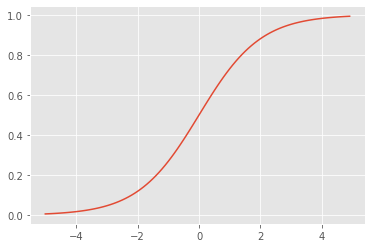

In [3]:
x = torch.arange(-5., 5., 0.1)
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())
plt.show()

As you can observe from the plot, the sigmoid function saturates (i.e., produces extreme valued outputs) very quickly and for a majority of the inputs. This can become a problem because it can lead to the gradients becoming either zero or diverging to an overflowing floating-point value. These phenomena are also known as vanishing gradient problem and exploding gradient problem, respectively. As a consequence, it is rare to see sigmoid units used in neural networks other than at the output, where the squashing property allows one to interpret outputs as probabilities.

### Tanh
The tanh activation function is a cosmetically different variant of the sigmoid. This becomes clear when you write down the expression for tanh:

$$\Large f(x)=\tanh x= \dfrac{e^x-e^{-x}}{e^x+e^{-x}} $$

With a little bit of wrangling (which we leave for you as an exercise), you can convince yourself that tanh is simply a linear transform of the sigmoid function, as shown in Example 3-3. This is also evident when you write down the PyTorch code for tanh() and plot the curve. Notice that tanh, like the sigmoid, is also a “squashing” function, except that it maps the set of real values from ($\large -\infty , +\infty$) to the range [-1, +1].

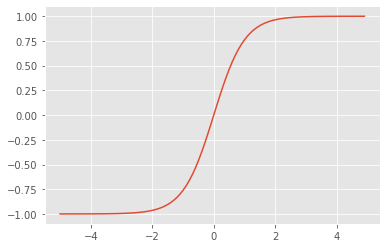

In [4]:
x = torch.arange(-5., 5., 0.1)
y = torch.tanh(x)
plt.plot(x.numpy(), y.numpy())
plt.show()

### ReLU

ReLU (pronounced ray-luh) stands for rectified linear unit. This is arguably the most important of the activation functions. In fact, one could venture as far as to say that many of the recent innovations in deep learning would’ve been impossible without the use of ReLU. For something so fundamental, it’s also surprisingly new as far as neural network activation functions go. And it’s surprisingly simple in form:

$$\Large f(x)=max(0,x)$$

So, all a ReLU unit is doing is clipping the negative values to zero, as demonstrated in Example 3-4.

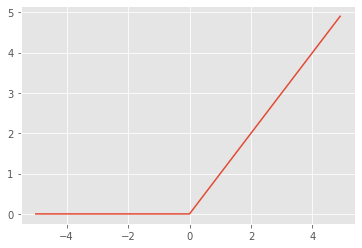

In [5]:
relu = torch.nn.ReLU()
x = torch.arange(-5., 5., 0.1)
y = relu(x)

plt.plot(x.numpy(), y.numpy())
plt.show()

The clipping effect of ReLU that helps with the vanishing gradient problem can also become an issue, where over time certain outputs in the network can simply become zero and never revive again. This is called the “dying ReLU” problem. To mitigate that effect, variants such as the Leaky ReLU and Parametric ReLU (PReLU) activation functions have proposed, where the leak coefficient a is a learned parameter. Example 3-5 shows the result.

$$\Large f(x)=max(x,ax)$$


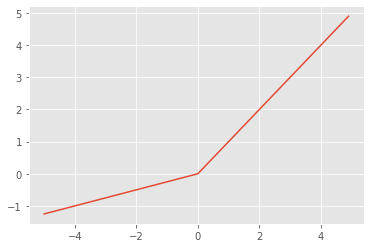

In [24]:
prelu = nn.PReLU(num_parameters=1)
x = torch.arange(-5., 5., 0.1)
y = prelu(x)

plt.plot(x.numpy(), y.detach().numpy())
plt.show()

### Softmax

Another choice for the activation function is the softmax. Like the sigmoid function, the softmax function squashes the output of each unit to be between 0 and 1, as shown in Example 3-6. However, the softmax operation also divides each output by the sum of all the outputs, which gives us a discrete probability distribution3 over k possible classes:

$$\Large softmax(x_i)= \dfrac{e^{x_i}}{\sum^k_{j=1} e^{x_j}}$$

The probabilities in the resulting distribution all sum up to one. This is very useful for interpreting outputs for classification tasks, and so this transformation is usually paired with a probabilistic training objective, such as categorical cross entropy, which is covered in “Diving Deep into Supervised Training”.

In [7]:
softmax = nn.Softmax(dim=1)
x_input = torch.randn(1, 3)
y_output = softmax(x_input)

print(x_input)
print(y_output)
print(torch.sum(y_output, dim=1))

tensor([[-1.4000,  0.7791,  0.4681]])
tensor([[0.0613, 0.5417, 0.3970]])
tensor([1.])


In this section, we studied four important activation functions: sigmoid, tanh, ReLU, and softmax. These are but four of the many possible activations that you could use in building neural networks. As we progress through this book, it will become clear which activation functions should be used and where, but a general guide is to simply follow what has worked in the past.

## Loss Functions
In Chapter 1, we saw the general supervised machine learning architecture and how loss functions or objective functions help guide the training algorithm to pick the right parameters by looking at the data. Recall that a loss function takes a truth (y) and a prediction (ŷ) as an input and produces a real-valued score. The higher this score, the worse the model’s prediction is. PyTorch implements more loss functions in its nn package than we can cover here, but we will review some of the most commonly used loss functions.

### Mean Squared Error Loss
For regression problems for which the network’s output ($\large \widehat{y}$) and the target ($\large y$) are continuous values, one common loss function is the mean squared error (MSE):

$$\Large \text{L}\textit{MSE}(y,\widehat{y})=\dfrac{1}{n} \sum^n_{i=1} (y-\widehat{y})^2$$

The MSE is simply the average of the squares of the difference between the predicted and target values. There are several other loss functions that you can use for regression problems, such as mean absolute error (MAE) and root mean squared error (RMSE), but they all involve computing a real-valued distance between the output and target. Example 3-7 shows how you can implement MSE loss using PyTorch.

In [8]:
mse_loss = nn.MSELoss()
outputs = torch.randn(3, 5, requires_grad=True)
targets = torch.randn(3, 5)
loss = mse_loss(outputs, targets)
print(loss)

tensor(2.3729, grad_fn=<MseLossBackward>)


### Categorical Cross-Entropy Loss
The categorical cross-entropy loss is typically used in a multiclass classification setting in which the outputs are interpreted as predictions of class membership probabilities. The target (y) is a vector of n elements that represents the true multinomial distribution4 over all the classes. If only one class is correct, this vector is a one-hot vector. The network’s output (ŷ) is also a vector of n elements but represents the network’s prediction of the multinomial distribution. Categorical cross entropy will compare these two vectors (y,ŷ) to measure the loss:

$$\Large \text{L} \textit{cross-entropy} (y,\widehat{y}) =- \sum _i y_{i} \ \log (\widehat{y} _i)$$

Cross-entropy and the expression for it have origins in information theory, but for the purpose of this section it is helpful to consider this as a method to compute how different two distributions are. We want the probability of the correct class to be close to 1, whereas the other classes have a probability close to 0.

To correctly use PyTorch’s CrossEntropyLoss() function, it is important to understand the relationship between the network’s outputs, how the loss function is computed, and the kinds of computational constraints that stem from really representing floating-point numbers. Specifically, there are four pieces of information that determine the nuanced relationship between network output and loss function. First, there is a limit to how small or how large a number can be. Second, if input to the exponential function used in the softmax formula is a negative number, the resultant is an exponentially small number, and if it’s a positive number, the resultant is an exponentially large number. Next, the network’s output is assumed to be the vector just prior to applying the softmax function.5 Finally, the log function is the inverse of the exponential function,6 and log(exp(x)) is just equal to x. Stemming from these four pieces of information, mathematical simplifications are made assuming the exponential function that is the core of the softmax function and the log function that is used in the cross-entropy computations in order to be more numerically stable and avoid really small or really large numbers. The consequences of these simplifications are that the network output without the use of a softmax function can be used in conjunction with PyTorch’s CrossEntropyLoss() to optimize the probability distribution. Then, when the network has been trained, the softmax function can be used to create a probability distribution, as shown in Example 3-8.

In [9]:
ce_loss = nn.CrossEntropyLoss()
outputs = torch.randn(3, 5, requires_grad=True)
targets = torch.tensor([1, 0, 3], dtype=torch.int64)
loss = ce_loss(outputs, targets)

print(loss)

tensor(1.6405, grad_fn=<NllLossBackward>)


In this code example, a vector of random values is first used to simulate network output. Then, the ground truth vector, called targets, is created as a vector of integers because PyTorch’s implementation of CrossEntropyLoss() assumes that each input has one particular class, and each class has a unique index. This is why targets has three elements: an index representing the correct class for each input. From this assumption, it performs the computationally more efficient operation of indexing into the model output.7

### Binary Cross-Entropy Loss
The categorical cross-entropy loss function we saw in the previous section is very useful in classification problems when we have multiple classes. Sometimes, our task involves discriminating between two classes—also known as binary classification. For such situations, it is efficient to use the binary cross-entropy (BCE) loss. We look at this loss function in action in “Example: Classifying Sentiment of Restaurant Reviews”.

In Example 3-9, we create a binary probability output vector, probabilities, using the sigmoid activation function on a random vector that represents the output of the network. Next, the ground truth is instantiated as a vector of 0’s and 1’s.8 Finally, we compute binary cross-entropy loss using the binary probability vector and the ground truth vector.

In [10]:
bce_loss = nn.BCELoss()
sigmoid = nn.Sigmoid()
probabilities = sigmoid(torch.randn(4, 1, requires_grad=True))
targets = torch.tensor([1, 0, 1, 0],  dtype=torch.float32).view(4, 1)
loss = bce_loss(probabilities, targets)
print(probabilities)
print(loss)

tensor([[0.2843],
        [0.4912],
        [0.5821],
        [0.6998]], grad_fn=<SigmoidBackward>)
tensor(0.9194, grad_fn=<BinaryCrossEntropyBackward>)


## Diving Deep into Supervised Training

Supervised learning is the problem of learning how to map observations to specified targets given labeled examples. In this section, we go into more detail. Specifically, we explicitly describe how to use model predictions and a loss function to do gradient-based optimization of a model’s parameters. This is an important section because the rest of the book relies on it, so it is worth going through it in detail even if you are somewhat familiar with supervised learning.

Recall from Chapter 1 that supervised learning requires the following: a model, a loss function, training data, and an optimization algorithm. The training data for supervised learning is pairs of observations and targets; the model computes predictions from the observations, and the loss measures the error of the predictions as compared to the targets. The goal of the training is to use the gradient-based optimization algorithm to adjust the model’s parameters so that the losses are as low as possible.

In the remainder of this section, we discuss a classic toy problem: classifying two-dimensional points into one of two classes. Intuitively, this means learning a single line, called a decision boundary or hyperplane, to discriminate the points of one class from the other. We step through and describe the data construction, choosing the model, selecting a loss function, setting up the optimization algorithm, and, finally, running it all together.

### Constructing Toy Data
In machine learning, it is a common practice to create synthetic data with well-understood properties when trying to understand an algorithm. For this section, we use synthetic data for the task of classifying two-dimensional points into one of two classes. To construct the data, we sample9 the points from two different parts of the xy-plane, creating an easy-to-learn situation for the model. Samples are shown in the plot depicted in Figure 3-2. The goal of the model is to classify the stars ($\large ⋆$) as one class, and the circles ($\large ◯$) as another class. This is visualized on the righthand side, where everything above the line is classified differently than everything below the line. The code for generating the data is in the function named get_toy_data() in the Python notebook that accompanies this chapter.

<div align="center" style="width: 100%;">
    <div align="center" style="width: 600px">
        <img src="imgs/nlpp_0302.png">
        <h4 style="font-family: courier; font-size: .8em;">Figure 3-2. Creating a toy dataset that’s linearly separable. The dataset is a sampling from two normal distributions, one for each class; the classification task becomes one of distinguishing whether a data point belongs to one distribution or the other.</h4>
    </div>
</div>

In [11]:
#Global Settings
LEFT_CENTER = (3, 3)
RIGHT_CENTER = (3, -2)

# Get Data Function
def get_toy_data(batch_size, left_center=LEFT_CENTER, right_center=RIGHT_CENTER):
    x_data = []
    y_targets = np.zeros(batch_size)
    for batch_i in range(batch_size):
        if np.random.random() > 0.5:
            x_data.append(np.random.normal(loc=left_center))
        else:
            x_data.append(np.random.normal(loc=right_center))
            y_targets[batch_i] = 1
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.float32)

# Visualizing Results Function
def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, epoch=None, title='', levels = None, linestyles = None):
    if levels is None:
        levels = [0.3, 0.4, 0.5]
    if linestyles is None:
        linestyles = ['--', '-', '--']
    y_pred = perceptron(x_data)
    y_pred = (y_pred > 0.5).long().data.numpy().astype(np.int32)

    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy().astype(np.int32)

    n_classes = 2

    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]

    colors = ['black', 'white']
    markers = ['o', '*']

    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append("white")
        else:
            all_colors[y_true_i].append("black")
        #all_colors[y_true_i].append(colors[y_pred_i])

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10,10))

    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor="black", marker=marker, facecolor=color_list, s=300)


    xlim = min(x_list[:, 0].min() for x_list in all_x), max(x_list[:, 0].max() for x_list in all_x)


    ylim = min(x_list[:, 1].min() for x_list in all_x), max(x_list[:, 1].max() for x_list in all_x)


    # hyperplane

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    Z = perceptron(torch.tensor(xy, dtype=torch.float32)).detach().numpy().reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=levels, linestyles=linestyles)    

    plt.suptitle(title)

    if epoch is not None:
        plt.text(xlim[0], ylim[1], f"Epoch = {str(epoch)}")

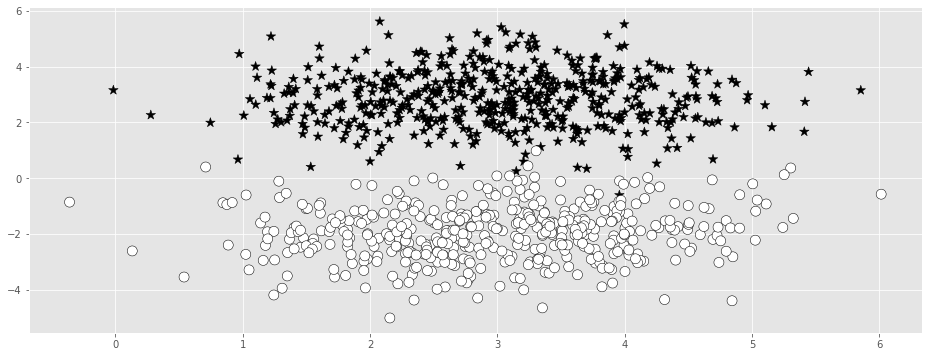

In [14]:
seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

x_data, y_truth = get_toy_data(batch_size=1000)

x_data = x_data.data.numpy()
y_truth = y_truth.data.numpy()

left_x = []
right_x = []
left_colors = []
right_colors =  []

color = 'black'

for x_i, y_true_i in zip(x_data, y_truth):
    if y_true_i == 0:
        left_x.append(x_i)
        left_colors.append(color)

    else:
        right_x.append(x_i)
        right_colors.append(color)

left_x = np.stack(left_x)
right_x = np.stack(right_x)

_, ax = plt.subplots(1, 1, figsize=(16,6))

ax.scatter(left_x[:, 0], left_x[:, 1], color=left_colors, marker='*', s=100)
ax.scatter(right_x[:, 0], right_x[:, 1], facecolor='white', edgecolor=right_colors, marker='o', s=100)

#plt.axis('off');
plt.show()

### CHOOSING A MODEL
The model we use here is the one introduced at the beginning of the chapter: the perceptron. The perceptron is flexible in that it allows for any input size. In a typical modeling situation, the input size is determined by the task and data. In this toy example, the input size is 2 because we explicitly constructed the data to be in a two-dimensional plane. For this two-class problem, we assign a numeric indices to the classes: 0 and 1. The mapping of the string labels $\large ⋆$ and $\large ◯$ to the class indexes is arbitrary as long as it is consistent throughout data preprocessing, training, evaluation, and testing. An important, additional property of this model is the nature of its output. Due to the perceptron’s activation function being a sigmoid, the output of the perceptron is the probability of the data point (x) being class 1; that is, $\large P(y = 1 | x)$.

### CONVERTING THE PROBABILITIES TO DISCRETE CLASSES
For the binary classification problem, we can convert the output probability into two discrete classes by imposing a decision boundary, $\large \delta$. If the predicted probability $\large P(y = 1 | x) > \delta$, the predicted class is 1, else the class is 0. Typically, this decision boundary is set to be 0.5, but in practice, you might need to tune this hyperparameter (using an evaluation dataset) to achieve a desired precision in classification.

### CHOOSING A LOSS FUNCTION
After you have prepared the data and selected a model architecture, there are two other vital components to choose in supervised training: a loss function and an optimizer. For situations in which the model’s output is a probability, the most appropriate family of loss functions are cross entropy–based losses. For this toy data example, because the model is producing binary outcomes, we specifically use the BCE loss.

### CHOOSING AN OPTIMIZER
The final choice point in this simplified supervised training example is the optimizer. While the model produces predictions and the loss function measures the error between predictions and targets, the optimizer updates the weights of the model using the error signal. In its simplest form, there is a single hyperparameter that controls the update behavior of the optimizer. This hyperparameter, called a learning rate, controls how much impact the error signal has on updating the weights. Learning rate is a critical hyperparameter, and you should try several different learning rates and compare them. Large learning rates will cause bigger changes to the parameters and can affect convergence. Too-small learning rates can result in very little progress during training.

The PyTorch library offers several choices for an optimizer. Stochastic gradient descent (SGD) is a classic algorithm of choice, but for difficult optimization problems, SGD has convergence issues, often leading to poorer models. The current preferred alternative are adaptive optimizers, such as Adagrad or Adam, which use information about updates over time.10 In the following example we use Adam, but it is always worth looking at several optimizers. With Adam, the default learning rate is 0.001. With hyperparameters such as learning rate, it’s always recommended to use the default values first, unless you have a recipe from a paper calling for a specific value.

```python
import torch.optim as optim

input_dim = 2
lr = 0.001

perceptron = Perceptron(input_dim=input_dim)
bce_loss = nn.BCELoss()
optimizer = optim.Adam(params=perceptron.parameters(), lr=lr)
```

## Putting It Together: Gradient-Based Supervised Learning

Learning begins with computing the loss; that is, how far off the model predictions are from the target. The gradient of the loss function, in turn, becomes a signal for “how much” the parameters should change. The gradient for each parameter represents instantaneous rate of change in the loss value given the parameter. Effectively, this means that you can know how much each parameter contributed to the loss function. Intuitively, this is a slope and you can imagine each parameter is standing on its own hill and wants to take a step up or down the hill. In its most minimal form, all that is involved with gradient-based model training is iteratively updating each parameter with the gradient of the loss function with respect to that parameter.

Let’s take a look at how this gradient-stepping algorithm looks. First, any bookkeeping information, such as gradients, currently stored inside the model (perceptron) object is cleared with a function named zero_grad(). Then, the model computes outputs (y_pred) given the input data (x_data). Next, the loss is computed by comparing model outputs (y_pred) to intended targets (y_target). This is the supervised part of the supervised training signal. The PyTorch loss object (criterion) has a function named backward() that iteratively propagates the loss backward through the computational graph and notifies each parameter of its gradient. Finally, the optimizer (opt) instructs the parameters how to update their values knowing the gradient with a function named step().

The entire training dataset is partitioned into batches. Each iteration of the gradient step is performed on a batch of data. A hyperparameter named batch_size specifies the size of the batches. Because the training dataset is fixed, increasing the batch size decreases the number of batches.

> NOTE
> In the literature, and also in this book, the term minibatch is used interchangeably with batch to highlight that each of the batches is significantly smaller than the size of the training data; for example, the training data size could be in the millions, whereas the minibatch could be just a few hundred in size.

After a number of batches (typically, the number of batches that are in a finite-sized dataset), the training loop has completed an epoch. An epoch is a complete training iteration. If the number of batches per epoch is the same as the number of batches in a dataset, then an epoch is a complete iteration over a dataset. Models are trained for a certain number of epochs. The number of epochs to train is not trivial to select, but there are methods for determining when to stop, which we discuss shortly. As Example 3-11 illustrates, the supervised training loop is thus a nested loop: an inner loop over a dataset or a set number of batches, and an outer loop, which repeats the inner loop over a fixed number of epochs or other termination criteria.

```python
# each epoch is a complete pass over the training data
for epoch_i in range(n_epochs):
    # the inner loop is over the batches in the dataset
    for batch_i in range(n_batches):

        # Step 0: Get the data
        x_data, y_target = get_toy_data(batch_size)

        # Step 1: Clear the gradients 
        perceptron.zero_grad()

        # Step 2: Compute the forward pass of the model
        y_pred = perceptron(x_data, apply_sigmoid=True)

        # Step 3: Compute the loss value that we wish to optimize
        loss = bce_loss(y_pred, y_target)

        # Step 4: Propagate the loss signal backward
        loss.backward()

        # Step 5: Trigger the optimizer to perform one update
        optimizer.step()
```

## Auxiliary Training Concepts
The core idea of supervised gradient-based learning is simple: define a model, compute outputs, use a loss function to compute gradients, and apply an optimization algorithm to update model parameters with the gradient. However, there are several auxiliary concepts that are important to the training process. We cover a few of them in this section.

### Correctly Measuring Model Performance: Evaluation Metrics
The most important component outside of the core supervised training loop is an objective measure of performance using data on which the model has never trained. Models are evaluated using one or more evaluation metrics. In natural language processing, there are multiple such metrics. The most common, and the one we will use in this chapter, is accuracy. Accuracy is simply the fraction of the predictions that were correct on a dataset unseen during training.

### Correctly Measuring Model Performance: Splitting the Dataset
It is important to always keep in mind that the final goal is to generalize well to the true distribution of data. What do we mean by that? There exists a distribution of data that exists globally assuming we were able see an infinite amount of data (“true/unseen distribution”). Obviously, we cannot do that. Instead, we make do with a finite sample that we call the training data. We observe a distribution of data in the finite sample that’s an approximation or an incomplete picture of the true distribution. A model is said to have generalized better than another model if it not only reduces the error on samples seen in the training data, but also on the samples from the unseen distribution. As the model works toward lowering its loss on the training data, it can “overfit” and adapt to idiosyncrasies that aren’t actually part of the true data distribution.

To accomplish this goal of generalizing well, it is standard practice to either split a dataset into three randomly sampled partitions (called the training, validation, and test datasets) or do k-fold cross validation. Splitting into three partitions is the simpler of the two methods because it only requires a single computation. You should take precautions to make sure the distribution of classes remains the same between each of the three splits, however. In other words, it is good practice to aggregate the dataset by class label and then randomly split each set separated by class label into the training, validation, and test datasets. A common split percentage is to reserve 70% for training, 15% for validation, and 15% for testing. This is not a hardcoded convention, though.

In some cases, a predefined training, validation, and test split might exist; this is common in datasets for benchmarking tasks. In such cases, it is important to use training data only for updating model parameters, use validation data for measuring model performance at the end of every epoch, and use test data only once, after all modeling choices are explored and the final results need to be reported. This last part is extremely important because the more the machine learning engineer peeks at the model performance on a test dataset, the more they are biased toward choices which perform better on the test set. When this happens, it is impossible to know how the model will perform on unseen data without gathering more data.

Model evaluation with k-fold cross validation is very similar to evaluation with predefined splits, but is preceded by an extra step of splitting the entire dataset into k equally sized “folds.” One of the folds is reserved for evaluation, and the remaining k-1 folds for training. This is iteratively repeated by swapping out the fold used for evaluation. Because there are k folds, each fold gets a chance to become an evaluation fold, resulting in k accuracy values. The final reported accuracy is simply the average with standard deviation. k–fold evaluation is computationally expensive but extremely necessary for smaller datasets, for which the wrong split can lead to either too much optimism (because the testing data wound up being too easy) or too much pessimism (because the testing data wound up being too hard).

### Knowing When to Stop Training
The example earlier trained the model for a fixed number of epochs. Although this is the simplest approach, it is arbitrary and unnecessary. One key function of correctly measuring model performance is to use that measurement to determine when training should stop. The most common method is to use a heuristic called early stopping. Early stopping works by keeping track of the performance on the validation dataset from epoch to epoch and noticing when the performance no longer improves. Then, if the performance continues to not improve, the training is terminated. The number of epochs to wait before terminating the training is referred to as the patience. In general, the point at which a model stops improving on some dataset is said to be when the model has converged. In practice, we rarely wait for a model to completely converge because convergence is time-consuming, and it can lead to overfitting.

### Finding the Right Hyperparameters
We learned earlier that a parameter (or weight) takes real values adjusted by an optimizer with respect to a fixed subset of training data called a minibatch. A hyperparameter is any model setting that affects the number of parameters in the model and values taken by the parameters. There are many different choices that go into determining how the model is trained. These include choosing a loss function; the optimizer; learning rate(s) for the optimizer, as layer sizes (covered in Chapter 4); patience for early stopping; and various regularization decisions (also covered in Chapter 4). It is important to be mindful that these decisions can have large effects on whether a model converges and its performance, and you should explore the various choice points systematically.

### Regularization
One of the most important concepts in deep learning (and machine learning, in general) is regularization. The concept of regularization comes from numerical optimization theory. Recall that most machine learning algorithms are optimizing the loss function to find the most likely values of the parameters (or “the model”) that explains the observations (i.e., produces the least amount of loss). For most datasets and tasks, there could be multiple solutions (possible models) to this optimization problem. So which one should we (or the optimizer) pick? To develop an intuitive understanding, consider Figure 3-3 for the task of fitting a curve through a set of points.

Both curves “fit” the points, but which one is an unlikely explanation? By appealing to Occam’s razor, we intuit that the simpler explanation is better than the complex one. This smoothness constraint in machine learning is called L2 regularization. In PyTorch, you can control this by setting the weight_decay parameter in the optimizer. The larger the weight_decay value, the more likely it is that the optimizer will select the smoother explanation (that is, the stronger is the L2 regularization).

<div align="center" style="width: 100%;">
    <div align="center" style="width: 500px">
        <img src="imgs/nlpp_0303.png">
        <h4 style="font-family: courier; font-size: .8em;">Figure 3-3. Both curves “fit” the points, but one of them seems more reasonable than the other—regularization helps us to select this more reasonable explanation (courtesy of Wikipedia).</h4>
    </div>
</div>

In addition to L2, another popular regularization is L1 regularization. L1 is usually used to encourage sparser solutions; in other words, where most of the model parameter values are close to zero. In Chapter 4, we will look at another structural regularization technique, called dropout. The topic of model regularization is an active area of research and PyTorch is a flexible framework for implementing custom regularizers.

# Example: Classifying Sentiment of Restaurant Reviews

In the previous section, we dove deep into supervised training with a toy example and illustrated many fundamental concepts. In this section we repeat that exercise, but this time with a real-world task and dataset: to classify whether restaurant reviews on Yelp are positive or negative using a perceptron and supervised training. Because this is the first full NLP example in this book, we will describe the assisting data structures and training routine in excruciating detail. The examples in later chapters will follow very similar patterns, so we encourage you to carefully follow along with this section and refer back to it as needed for a refresher [11].

At the start of each example in this book, we describe the dataset that we are using. In this example we use the Yelp dataset, which pairs reviews with their sentiment labels (positive or negative). We additionally describe a couple of dataset manipulation steps we took to clean and partition it into training, validation, and test sets.

After understanding the dataset, you will see a pattern defining three assisting classes that is repeated throughout this book and is used to transform text data into a vectorized form: the `Vocabulary`, the `Vectorizer`, and PyTorch’s `DataLoader`. The `Vocabulary` coordinates the integer-to-token mappings that we discussed in [“Observation and Target Encoding”]. We use a `Vocabulary` both for mapping the text tokens to integers and for mapping the class labels to integers. Next, the `Vectorizer` encapsulates the vocabularies and is responsible for ingesting string data, like a review’s text, and converting it to numerical vectors that will be used in the training routine. We use the final assisting class, PyTorch’s `DataLoader`, to group and collate the individual vectorized data points into minibatches.

The following section describes the perceptron classifier and its training routine. The training routine mostly remains the same for every example in this book, but we discuss it in more detail in this section, so again, we encourage you to use this example as a reference for future training routines. We conclude the example by discussing the results and taking a peek under the hood to see what the model learned.

## The Yelp Review Dataset

In 2015, Yelp held a contest in which it asked participants to predict the rating of a restaurant given its review. Zhang, Zhao, and Lecun (2015) simplified the dataset by converting the 1- and 2-star ratings into a “negative” sentiment class and the 3- and 4-star ratings into a “positive” sentiment class, and split it into 560,000 training samples and 38,000 testing samples. In this example we use the simplified Yelp dataset, with two minor differences. In the remainder of this section, we describe the process by which we minimally clean the data and derive our final dataset. Then, we outline the implementation that utilizes PyTorch’s `Dataset` class.

The first of the differences mentioned is that we use a “light” version of the dataset, which is derived by selecting 10% of the training samples as the full dataset[12]. This has two consequences. First, using a small dataset makes the training–testing loop fast, so we can experiment quickly. Second, it produces a model with lower accuracy than would be achieved by using all of the data. This low accuracy is usually not a major issue, because you can retrain with the entire dataset using the knowledge gained from the smaller subset. This is a very useful trick in training deep learning models, where the amount of training data in many situations can be enormous.

From this smaller subset, we split the dataset into three partitions: one for training, one for validation, and one for testing. Although the original dataset has only two partitions, it’s important to have a validation set. In machine learning, you will often train a model on the training partition of a dataset and require a held-out partition for evaluating how well the model did. If model decisions are based on that held-out portion, the model will inevitably be biased toward performing better on the held-out portion. Because measuring incremental progress is vital, the solution to this problem is to have a third partition, which is used for evaluation as little as possible.

To summarize, you should use the training partition of a dataset to derive model parameters, the validation partition of a dataset for selecting among hyperparameters (making modeling decisions), and the testing partition of the dataset for final evaluation and reporting[13]. In [Example 3-12], we show how we split the dataset. Note that the random seed is set to a static number and that we first aggregate by class label to guarantee the class distribution remains the same.

##### Example 3-12. Creating training, validation, and testing splits

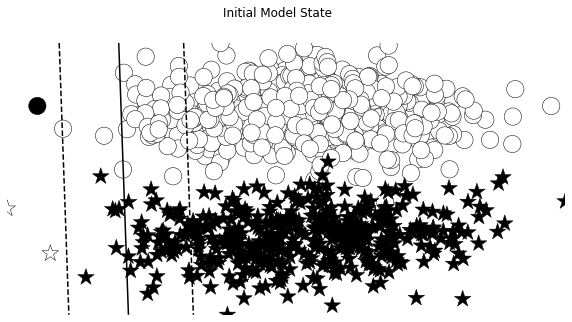

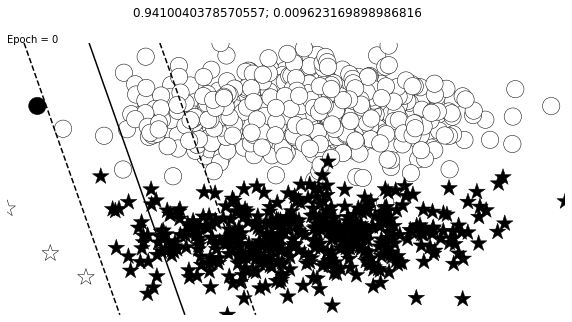

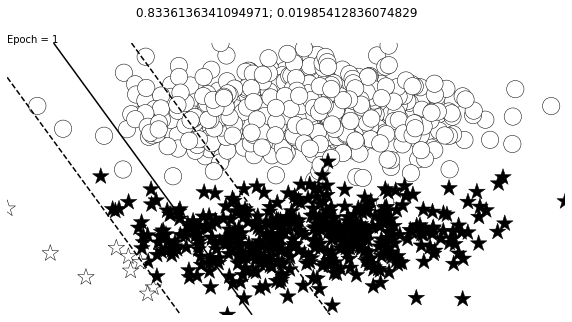

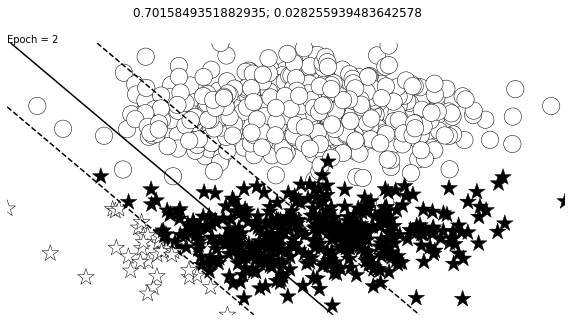

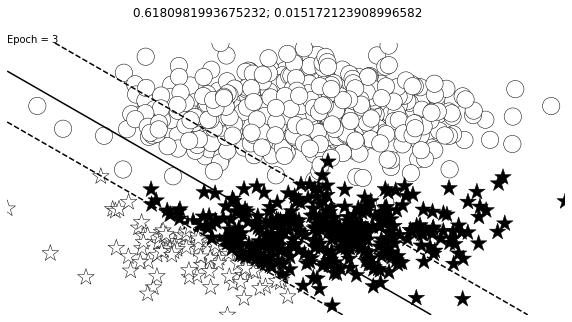

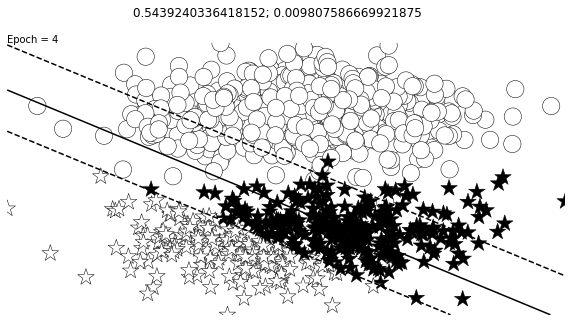

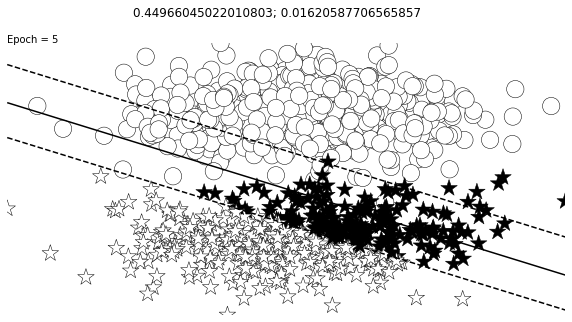

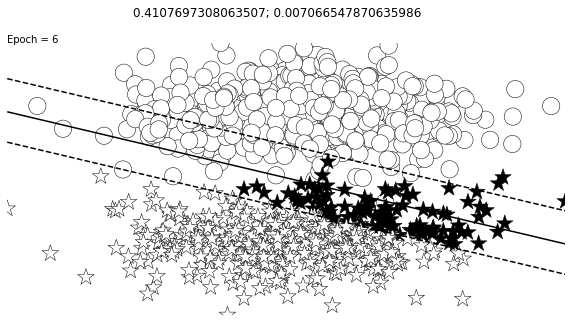

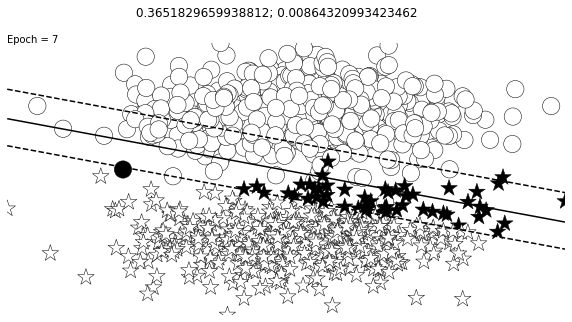

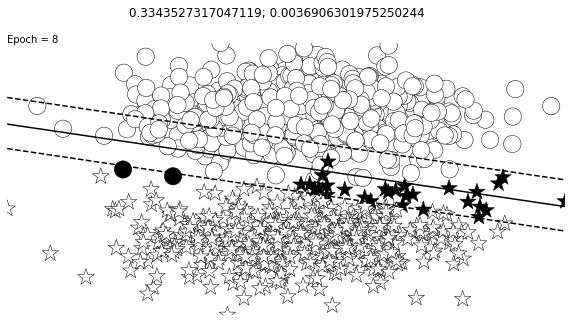

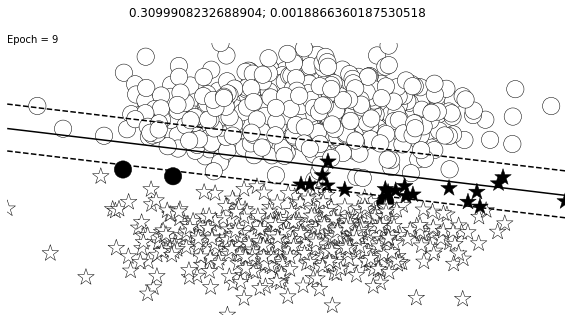

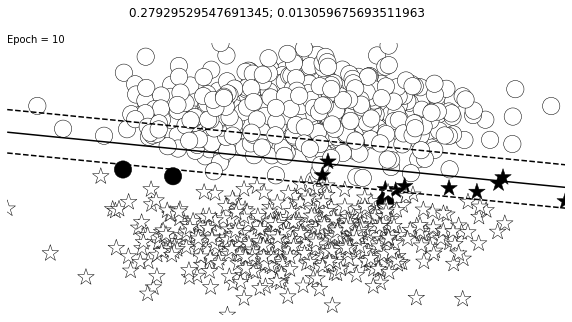

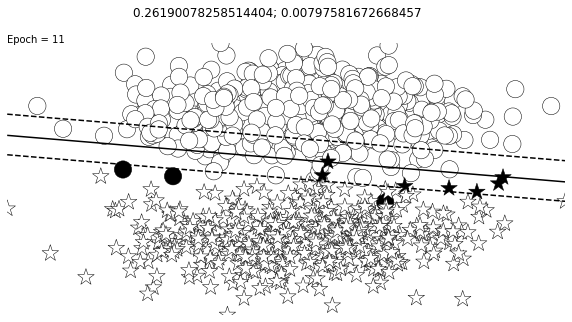

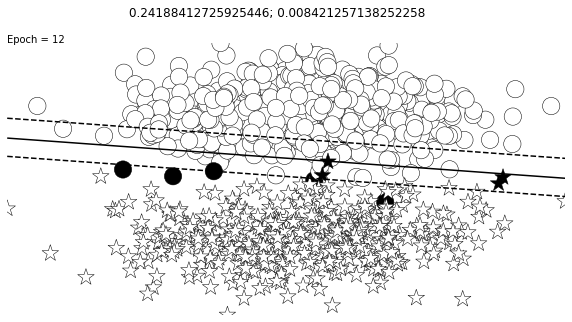

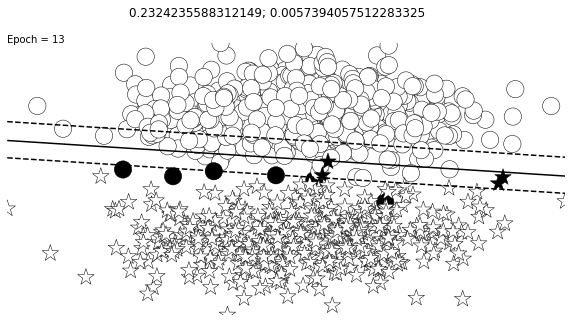

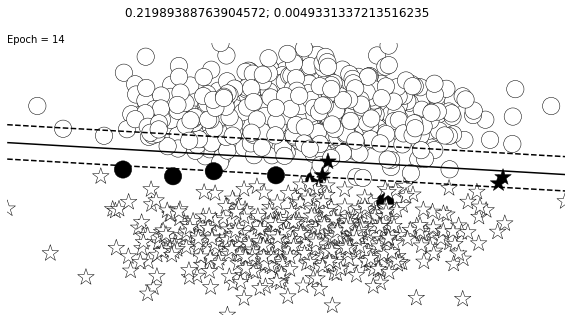

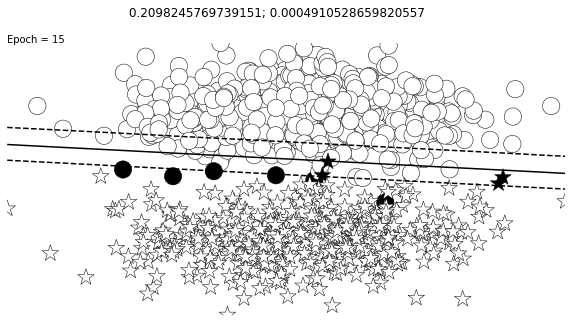

In [17]:
lr = 0.01
input_dim = 2

batch_size = 1000
n_epochs = 12
n_batches = 5

seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

perceptron = Perceptron(input_dim=input_dim)
optimizer = optim.Adam(params=perceptron.parameters(), lr=lr)
bce_loss = nn.BCELoss()

losses = []

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(perceptron, x_data_static, y_truth_static, ax=ax, title='Initial Model State')
plt.axis('off')
#plt.savefig('initial.png')

change = 1.0
last = 10.0
epsilon = 1e-3
epoch = 0
while change > epsilon or epoch < n_epochs or last > 0.3:
#for epoch in range(n_epochs):
    for _ in range(n_batches):

        optimizer.zero_grad()
        x_data, y_target = get_toy_data(batch_size)
        y_pred = perceptron(x_data).squeeze()
        loss = bce_loss(y_pred, y_target)
        loss.backward()
        optimizer.step()
        
        
        loss_value = loss.item()
        losses.append(loss_value)

        change = abs(last - loss_value)
        last = loss_value
               
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    visualize_results(perceptron, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                      title=f"{loss_value}; {change}")
    plt.axis('off')
    epoch += 1
    #plt.savefig('epoch{}_toylearning.png'.format(epoch))

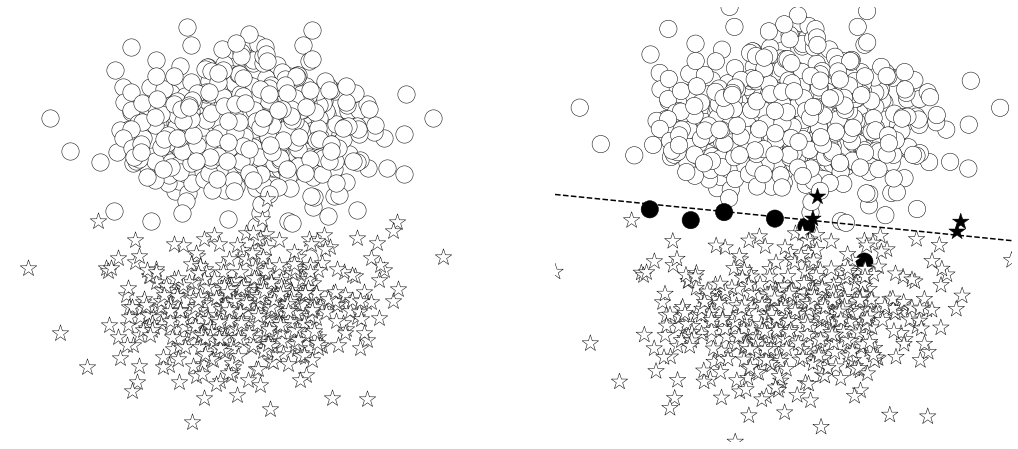

In [23]:
_, axes = plt.subplots(1,2,figsize=(18,8))


axes[0].scatter(left_x[:, 0], left_x[:, 1], facecolor='white',edgecolor='black', marker='o', s=300)
axes[0].scatter(right_x[:, 0], right_x[:, 1], facecolor='white', edgecolor='black', marker='*', s=300)
axes[0].axis('off');
visualize_results(perceptron, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[1])
axes[1].axis('off');
#plt.savefig('perceptron_final.png')
#plt.savefig('perceptron_final.pdf')
plt.show()